# Reddit Post Popularity Prediction
<hr>

**Objective** : Predict the popularity of Reddit posts based on their content and metadata.

### Step 1: Import Libraries

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade pandas numpy praw requests transformers nltk spacy en-core-web-sm scikit-learn torch matplotlib seaborn tqdm;

In [3]:
import os

# import libraries
import pandas as pd
import numpy as np
import praw
import matplotlib.pyplot as plt
import seaborn as sns

### Step 2: Data Collection

#### 2.1: Reddit API Access

In [5]:
reddit = praw.Reddit(
    client_id=MY_CLIENT_ID,
    client_secret=MY_CLIENT_SECRET,
    user_agent=f'post popularity prediction by u/{MY_USERNAME}',
    username=MY_USERNAME,
    password=MY_PASSWORD,
)

#### 2.2: Data Collection from Reddit

In [6]:
# subreddit selection
subreddits = ['sports', 'technology', 'news', 'politics', 'movies']

Define Data Collection Parameters:

<li>Time Frame: Posts from the past week, month, year, etc.
<li>Sorting Method: Hot, New, Top.
<li>Limit: Number of posts to retrieve.

In [7]:
data = []

for subreddit_name in subreddits:
    subreddit = reddit.subreddit(subreddit_name)
    
    for submission in subreddit.top(time_filter='year' ,limit=1000):
        post = {}
        post['id'] = submission.id
        post['title'] = submission.title
        post['selftext'] = submission.selftext
        post['score'] = submission.score  #upvotes
        post['num_comments'] = submission.num_comments
        post['subreddit'] = subreddit_name
        post['upvote_ratio'] = submission.upvote_ratio
        post['created_utc'] = submission.created_utc
        data.append(post)

In [9]:
# convert data to dataframe

df = pd.DataFrame(data)
df.head()

,id,title,selftext,score,num_comments,subreddit,upvote_ratio,created_utc
0,1326zch,"Dwyane Wade, who has trans daughter, says he l...",,48233,1807,sports,0.76,1.682709e+09
1,138iues,Lewis Hamilton speaks out against Florida’s LG...,,24823,1507,sports,0.82,1.683286e+09
2,192czfc,Jimmy Kimmel's monologue response tonight to A...,,23580,1469,sports,0.77,1.704801e+09
3,12qnl6y,Snoop Dogg applauds NBA for new cannabis polic...,,23440,653,sports,0.91,1.681826e+09
4,14bqsw1,NCAA committee recommends dropping marijuana f...,,21929,685,sports,0.94,1.687007e+09


,id,title,selftext,score,num_comments,subreddit,upvote_ratio,created_utc
4911,1951drg,A Super Man: New Christopher Reeve Doc Shows H...,,2700,230,movies,0.96,1.705082e+09
4912,14vtqkb,Alternate poster for Napoleon,,2692,188,movies,0.95,1.688995e+09
4913,14vehxu,Did You Go See A Movie Where The Audience Almo...,For me it was Austin Powers Goldmember. Someho...,2692,2000,movies,0.91,1.688948e+09
4914,19d5ijj,"Norman Jewison Dies: ‘Fiddler On The Roof,’ ‘M...",,2681,163,movies,0.95,1.705956e+09
4915,198zyrt,Warner Bros’ Jason Momoa ‘Minecraft’ Movie Add...,,2677,464,movies,0.88,1.705507e+09


In [12]:
# store the data locally
df.to_csv('reddit_posts.csv', index=False)

#### 2.3: Data Exploration

In [17]:
# basic information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4916 entries, 0 to 4915
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4916 non-null   object 
 1   title         4916 non-null   object 
 2   selftext      4916 non-null   object 
 3   score         4916 non-null   int64  
 4   num_comments  4916 non-null   int64  
 5   subreddit     4916 non-null   object 
 6   upvote_ratio  4916 non-null   float64
 7   created_utc   4916 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 307.4+ KB
None


In [18]:
# check for missing values
print(df.isnull().sum())

id              0
title           0
selftext        0
score           0
num_comments    0
subreddit       0
upvote_ratio    0
created_utc     0
dtype: int64


In [25]:
# check for duplicates
print(df.duplicated().sum())

0


In [19]:
# summary statistics
print(df.describe())

               score  num_comments  upvote_ratio   created_utc
count    4916.000000   4916.000000   4916.000000  4.916000e+03
mean    14654.689788   1367.934093      0.924843  1.695900e+09
std     13484.319366   1528.358056      0.038725  9.610013e+06
min       654.000000      0.000000      0.660000  1.680695e+09
25%      4496.250000    426.000000      0.910000  1.687142e+09
50%     11503.000000    956.000000      0.930000  1.695435e+09
75%     20804.250000   1775.250000      0.950000  1.704660e+09
max    133696.000000  24969.000000      0.980000  1.712191e+09


In [20]:
# value counts of subreddit
print(df['subreddit'].value_counts())

politics      991
sports        985
technology    985
movies        983
news          972
Name: subreddit, dtype: int64


### Step 3: Data Preprocessing

#### 3.1: Load the Local Data (if needed)

In [4]:
df = pd.read_csv('reddit_posts.csv')

#### 3.2: Text Preprocessing

Integrate LangChain and a pre-trained LLM from Hugging Face to process your text data.

In [5]:
# !pip install -U langchain-community langchain;
# !pip install docarray huggingface-hub;
# !pip install sentence-transformers;

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings
from huggingface_hub import login

/Users/shagundeepsingh/PycharmProjects/Reddit_post_popularity_predict/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in HuggingFaceInferenceAPIEmbeddings has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [17]:
# authenticate with Hugging Face
login(os.environ["HF_TOKEN"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /Users/shagundeepsingh/.cache/huggingface/token
Login successful


#### 3.3: Text Embeddings

In [10]:
# set up the LLM
embeddings_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
embeddings = HuggingFaceEmbeddings(model_name=embeddings_model_name)


/Users/shagundeepsingh/PycharmProjects/Reddit_post_popularity_predict/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
df['selftext'].isna().sum()
df.selftext.fillna('', inplace=True)
df.selftext[0]

''

In [12]:
# Combine title and selftext
df['text'] = df['title'] + ' ' + df['selftext']

In [13]:
# generate text embeddings

## Convert the 'text' column to a list
texts = df['text'].tolist()

print(texts[:2])
## Generate embeddings
text_embeddings = embeddings.embed_documents(texts)

["Dwyane Wade, who has trans daughter, says he left Florida because his family 'would not be accepted' there ", 'Lewis Hamilton speaks out against Florida’s LGBTQ laws ahead of Miami Grand Prix ']


In [14]:
# Add embeddings to the DataFrame
df['text_embeddings'] = text_embeddings

In [15]:
df['text_embeddings'][0]

[-0.016828443855047226,
 0.002613351447507739,
 -0.03808185085654259,
 -0.002766822697594762,
 0.06513313204050064,
 -0.07134400308132172,
 0.0932239443063736,
 -0.029222795739769936,
 0.009847457520663738,
 0.009741717018187046,
 -0.02159333974123001,
 0.01498539187014103,
 0.02901567704975605,
 0.0506109856069088,
 0.06919331103563309,
 0.01725013740360737,
 -0.018974773585796356,
 0.008761056698858738,
 -0.02117946743965149,
 -0.05632620304822922,
 -0.02760344371199608,
 0.06698371469974518,
 0.025307660922408104,
 -0.033121977001428604,
 -0.005851214285939932,
 -0.015182852745056152,
 -0.011107738129794598,
 0.07368657737970352,
 -0.012495454400777817,
 0.06022687628865242,
 -0.016442760825157166,
 -0.011727050878107548,
 -0.08997367322444916,
 0.06281277537345886,
 -0.017174558714032173,
 -0.07545088231563568,
 -0.0982080027461052,
 0.07739756256341934,
 6.156624294817448e-05,
 -0.03893442824482918,
 0.03190550208091736,
 -0.012096064165234566,
 0.07122227549552917,
 0.02809336967

In [16]:
# flatten the embeddings

# convert the embeddings to a numpy array
embeddings_array = np.array(df['text_embeddings'].tolist())

embeddings_array.shape

(4916, 384)

In [17]:
# Create column names for embeddings
embedding_dim = embeddings_array.shape[1]
embedding_cols = [f'embedding_{i}' for i in range(embedding_dim)]

In [18]:
# Create a DataFrame from embeddings
embeddings_df = pd.DataFrame(embeddings_array, columns=embedding_cols)

embeddings_df.sample()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_374,embedding_375,embedding_376,embedding_377,embedding_378,embedding_379,embedding_380,embedding_381,embedding_382,embedding_383
2041,-0.033772,0.033501,-0.01776,-0.007973,0.069476,0.01054,0.036611,0.064876,0.03074,0.030572,...,-0.042041,0.12151,0.009297,-0.036692,-0.043815,0.019717,-0.052879,0.013216,0.101345,-0.033666


In [19]:
# Concatenate embeddings with the main DataFrame
df = pd.concat([df.reset_index(drop=True), embeddings_df.reset_index(drop=True)], axis=1)
# Drop the original 'text_embeddings' column
df = df.drop(columns=['text_embeddings'])

#### 3.4: Feature Engineering

In [20]:
df['created_datetime'] = pd.to_datetime(df['created_utc'], unit='s')
df['hour'] = df['created_datetime'].dt.hour
df['day'] = df['created_datetime'].dt.day
df['month'] = df['created_datetime'].dt.month
df['year'] = df['created_datetime'].dt.year
df['day_of_week'] = df['created_datetime'].dt.dayofweek  # Monday=0, Sunday=6
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

In [21]:
# calculate text length
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

In [22]:
# sentiment analysis
from transformers import pipeline

# Load a sentiment-analysis pipeline
sentiment_pipeline = pipeline('sentiment-analysis')

# Apply sentiment analysis (this can be slow)
df['sentiment'] = df['text'].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/Users/shagundeepsingh/PycharmProjects/Reddit_post_popularity_predict/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [23]:
df['sentiment'].value_counts()

NEGATIVE    3657
POSITIVE    1259
Name: sentiment, dtype: int64

In [24]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['subreddit'], prefix='subreddit')
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow')
df = pd.get_dummies(df, columns=['sentiment'], prefix='sentiment')

In [25]:
# Select numerical columns
numeric_cols = [
    'score', 'num_comments', 'upvote_ratio', 'text_length',
    'hour', 'day', 'month', 'year'
] + embedding_cols  # Add embedding columns

In [26]:
# Save preprocessed data
df.to_pickle('reddit_posts_preprocessed.pkl')

In [27]:
df.head()

,id,title,selftext,score,num_comments,upvote_ratio,created_utc,text,embedding_0,embedding_1,...,subreddit_technology,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,sentiment_NEGATIVE,sentiment_POSITIVE
0,1326zch,"Dwyane Wade, who has trans daughter, says he l...",,48233,1807,0.76,1.682709e+09,"Dwyane Wade, who has trans daughter, says he l...",-0.016828,0.002613,...,0,0,0,0,0,1,0,0,1,0
1,138iues,Lewis Hamilton speaks out against Florida’s LG...,,24823,1507,0.82,1.683286e+09,Lewis Hamilton speaks out against Florida’s LG...,0.035826,0.082699,...,0,0,0,0,0,1,0,0,0,1
2,192czfc,Jimmy Kimmel's monologue response tonight to A...,,23580,1469,0.77,1.704801e+09,Jimmy Kimmel's monologue response tonight to A...,-0.007393,0.066174,...,0,0,1,0,0,0,0,0,1,0
3,12qnl6y,Snoop Dogg applauds NBA for new cannabis polic...,,23440,653,0.91,1.681826e+09,Snoop Dogg applauds NBA for new cannabis polic...,0.037619,0.043077,...,0,0,1,0,0,0,0,0,1,0
4,14bqsw1,NCAA committee recommends dropping marijuana f...,,21929,685,0.94,1.687007e+09,NCAA committee recommends dropping marijuana f...,0.069799,0.060094,...,0,0,0,0,0,0,1,0,1,0


### Step 4: Exploratory Data Analysis (EDA)
#### 4.1: Load the Preprocessed Data (if needed)

In [28]:
df = pd.read_pickle('reddit_posts_preprocessed.pkl')

In [29]:
# Identify numerical and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['score', 'num_comments', 'upvote_ratio', 'created_utc', 'embedding_0', 'embedding_1', 'embedding_2', 'embedding_3', 'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7', 'embedding_8', 'embedding_9', 'embedding_10', 'embedding_11', 'embedding_12', 'embedding_13', 'embedding_14', 'embedding_15', 'embedding_16', 'embedding_17', 'embedding_18', 'embedding_19', 'embedding_20', 'embedding_21', 'embedding_22', 'embedding_23', 'embedding_24', 'embedding_25', 'embedding_26', 'embedding_27', 'embedding_28', 'embedding_29', 'embedding_30', 'embedding_31', 'embedding_32', 'embedding_33', 'embedding_34', 'embedding_35', 'embedding_36', 'embedding_37', 'embedding_38', 'embedding_39', 'embedding_40', 'embedding_41', 'embedding_42', 'embedding_43', 'embedding_44', 'embedding_45', 'embedding_46', 'embedding_47', 'embedding_48', 'embedding_49', 'embedding_50', 'embedding_51', 'embedding_52', 'embedding_53', 'embedding_54', 'embedding_55', 'embedding_56', 'embedding_57', 'embeddi

#### 4.2: Visualize Distributions of Key Variables

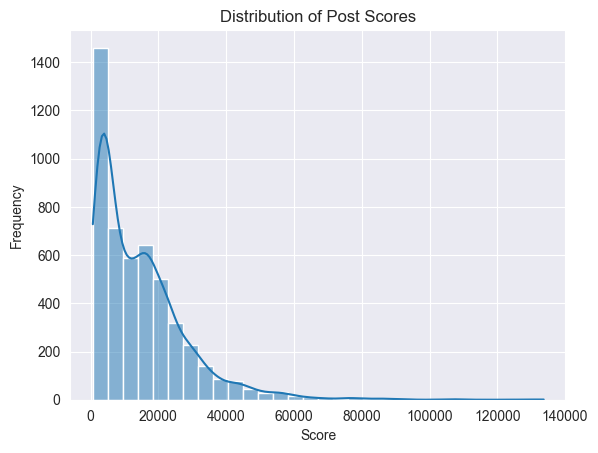

In [30]:
# understanding data distribution
# histogram of posts
sns.histplot(df['score'], kde=True, bins=30)
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

As the distribution is skewed, we can apply a log transformation to make it more normal.

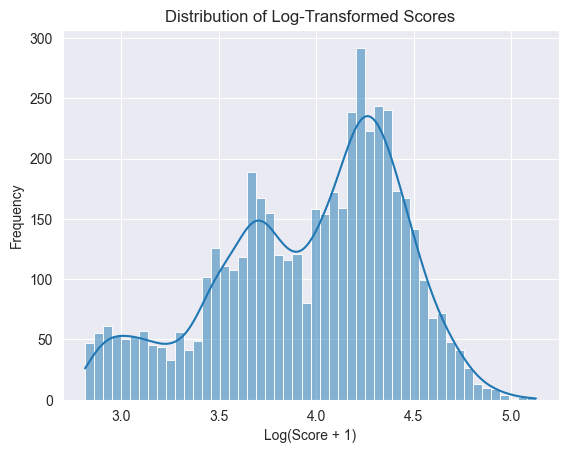

In [31]:
# Apply log transformation
df['log_score'] = np.log10(df['score'])

sns.histplot(df['log_score'], bins=50, kde=True)
plt.title('Distribution of Log-Transformed Scores')
plt.xlabel('Log(Score + 1)')
plt.ylabel('Frequency')
plt.show()

Distribution of numerical features

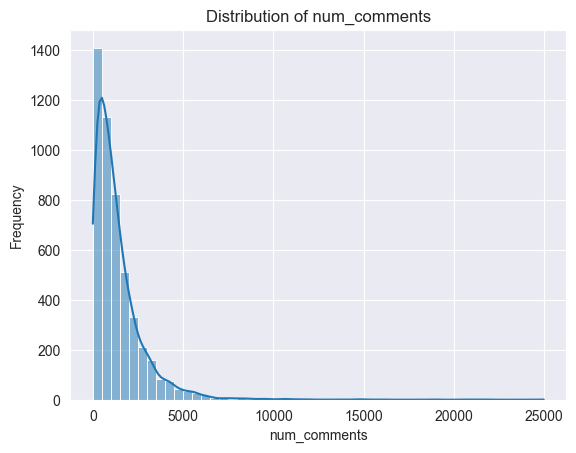

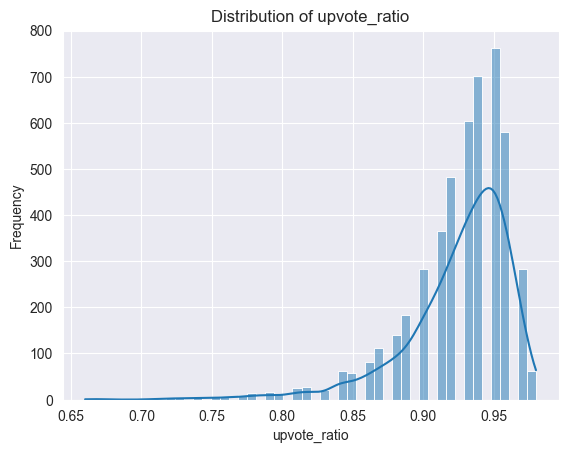

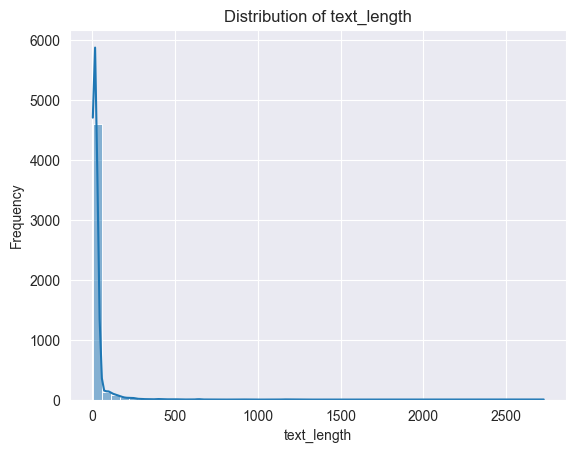

In [32]:
numerical_features = ['num_comments', 'upvote_ratio', 'text_length']

for col in numerical_features:
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

Distribution of time features

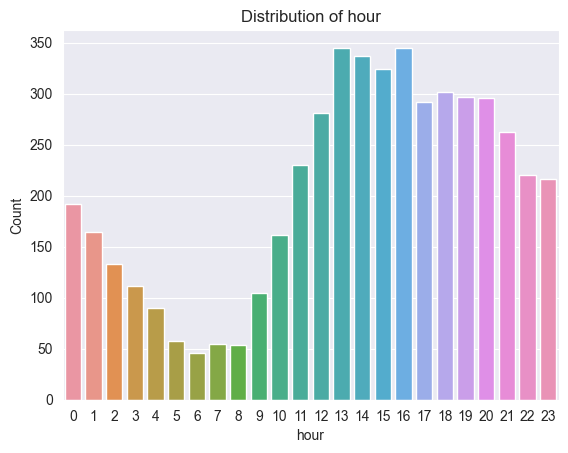

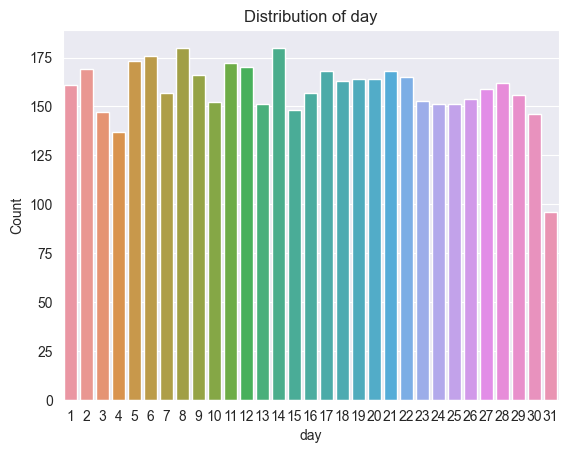

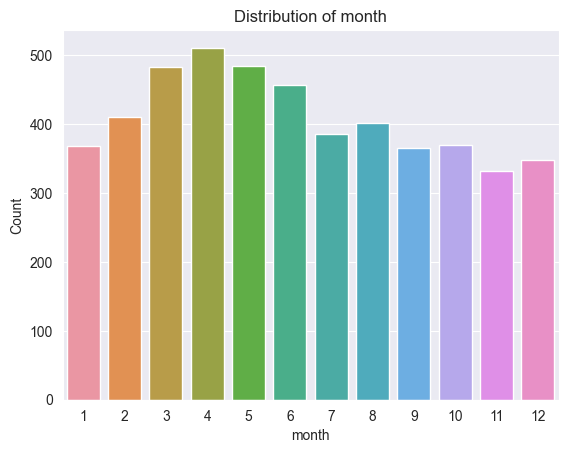

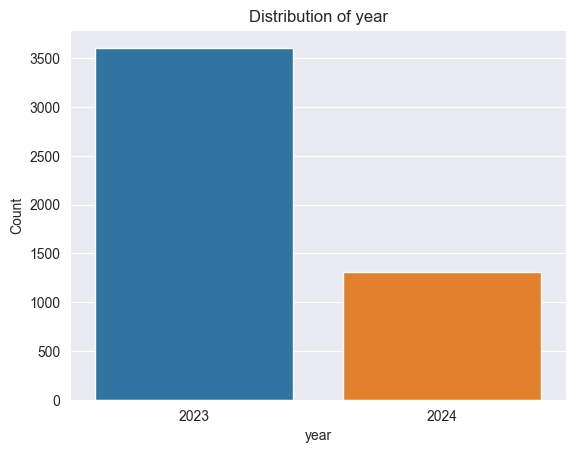

In [33]:
time_features = ['hour', 'day', 'month', 'year']

for col in time_features:
    sns.countplot(x=col, data=df)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

#### 4.3: Analyze Relationships Between Variables

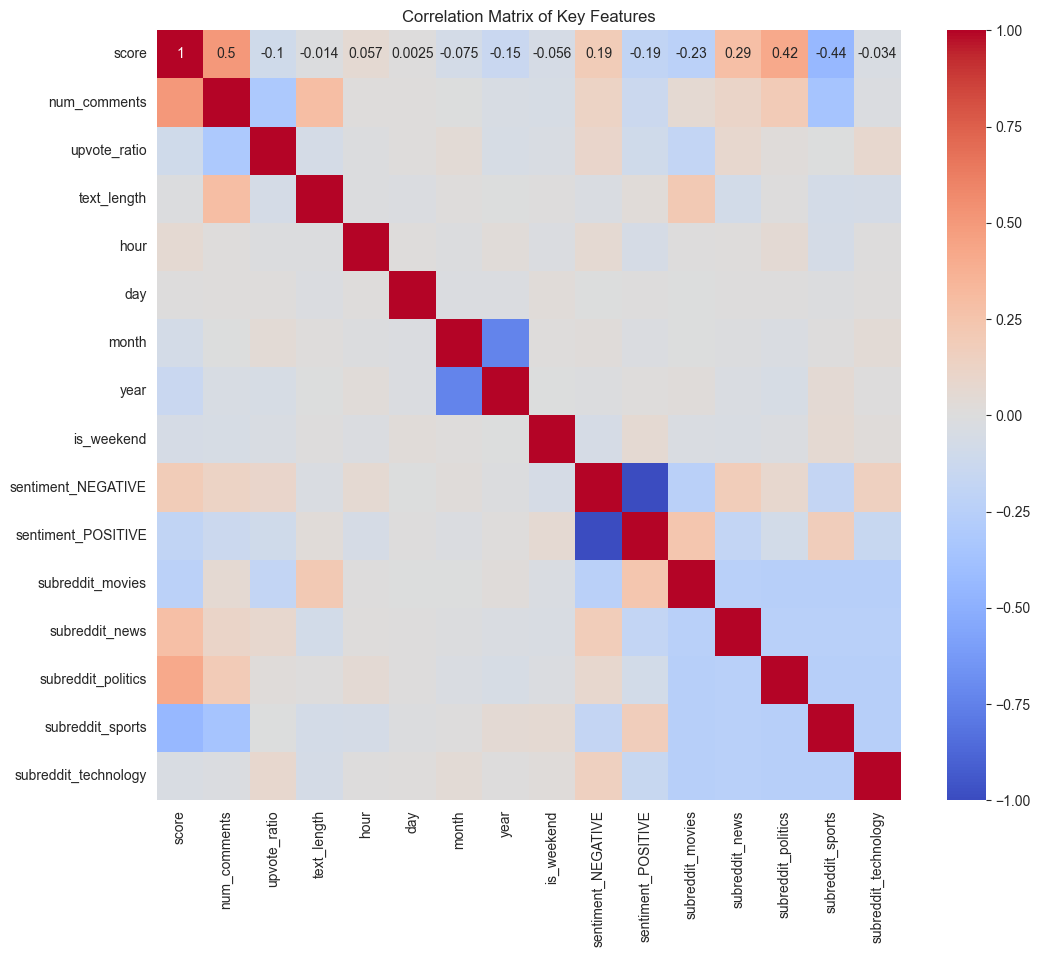

In [34]:
# Select a subset of features for correlation analysis (excluding embeddings for clarity)
corr_features = ['score', 'num_comments', 'upvote_ratio', 'text_length',
                 'hour', 'day', 'month', 'year', 'is_weekend',
                 'sentiment_NEGATIVE', 'sentiment_POSITIVE'] + [
                     'subreddit_movies', 'subreddit_news', 'subreddit_politics',
                     'subreddit_sports', 'subreddit_technology'
                 ]

corr_matrix = df[corr_features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Key Features')
plt.show()

Observations:
<ol>
<li>Posts in certain subreddits like movies and politics tend to have higher scores and more comments.
<li>Time features (hour, day, month) and sentiment are relatively weak predictors of score or other key metrics.
<li>A notable negative relationship exists between the technology subreddit and score, suggesting that posts in this subreddit tend to receive lower scores compared to others.
</ol>

<br>
Features with strong positive correlation with score:

<li>Number of comments: 0.5
<li>Subreddit_movies: 0.29
<li>Subreddit_politics: 0.42
<br><br>
Features with strong negative correlation with score:

<li>Subreddit_technology: -0.44

#### 4.4: Analyze the Relationship Between Score and other Features
##### 4.4.1: Score vs. Number of Comments

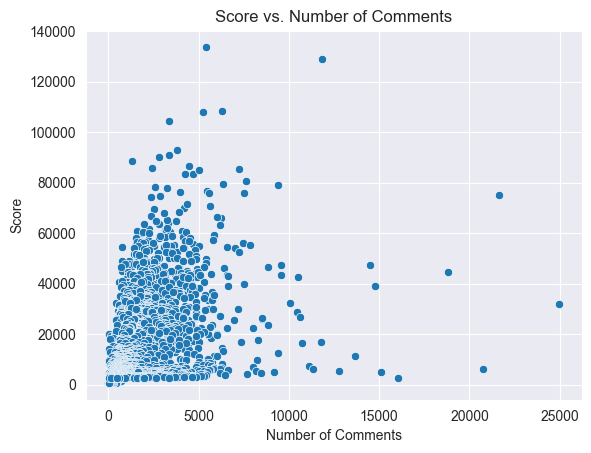

In [35]:
# Scatter plot of score vs. number of comments
sns.scatterplot(x='num_comments', y='score', data=df)
plt.title('Score vs. Number of Comments')
plt.xlabel('Number of Comments')
plt.ylabel('Score')
plt.show()

##### 4.4.2: Score vs. Upvote Ratio

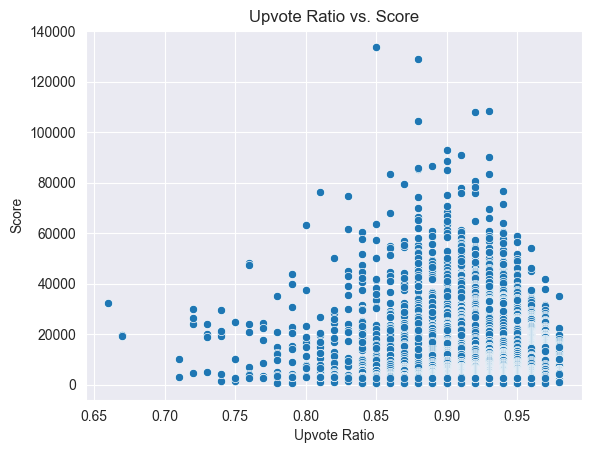

In [36]:
# Scatter plot of score vs. upvote ratio
sns.scatterplot(x='upvote_ratio', y='score', data=df)
plt.title('Upvote Ratio vs. Score')
plt.xlabel('Upvote Ratio')
plt.ylabel('Score')
plt.show()

##### 4.4.3: Score vs. Text Length

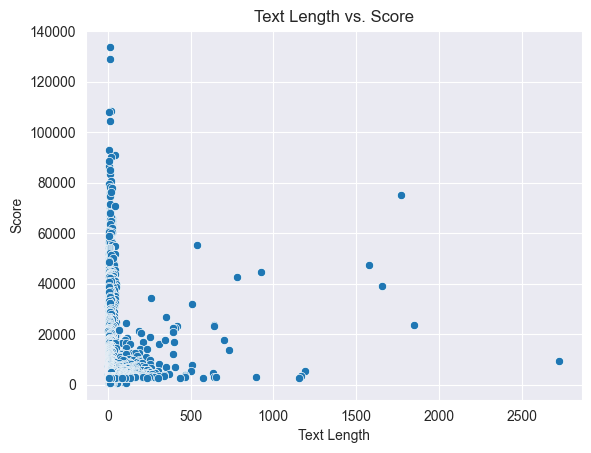

In [37]:
# Scatter plot of score vs. text length
sns.scatterplot(x='text_length', y='score', data=df)
plt.title('Text Length vs. Score')
plt.xlabel('Text Length')
plt.ylabel('Score')
plt.show()

#### 4.5: Box Plots for Categorical Variables: Subreddit and Sentiment

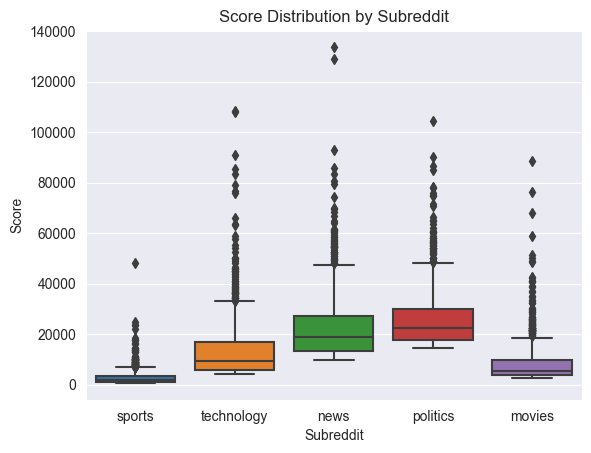

In [38]:
# First, create a 'subreddit' column from one-hot encoded features
subreddit_cols = ['subreddit_movies', 'subreddit_news', 'subreddit_politics',
                  'subreddit_sports', 'subreddit_technology']
df['subreddit'] = df[subreddit_cols].idxmax(axis=1).str.replace('subreddit_', '')

sns.boxplot(x='subreddit', y='score', data=df)
plt.title('Score Distribution by Subreddit')
plt.xlabel('Subreddit')
plt.ylabel('Score')
plt.show()

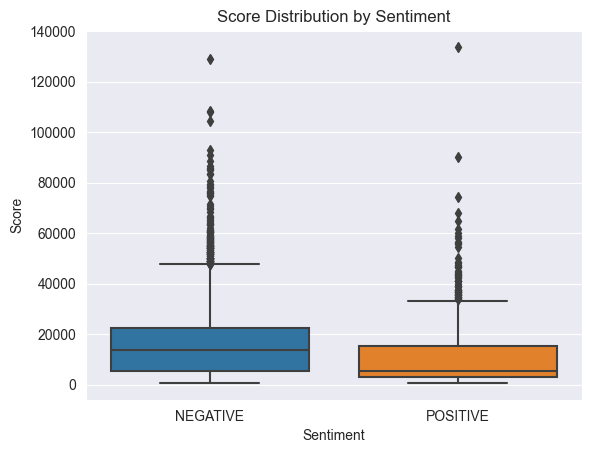

In [39]:
# Box plot of score by sentiment
sentiment_cols = ['sentiment_NEGATIVE', 'sentiment_POSITIVE']
df['sentiment'] = df[sentiment_cols].idxmax(axis=1).str.replace('sentiment_', '')

sns.boxplot(x='sentiment', y='score', data=df)
plt.title('Score Distribution by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.show()

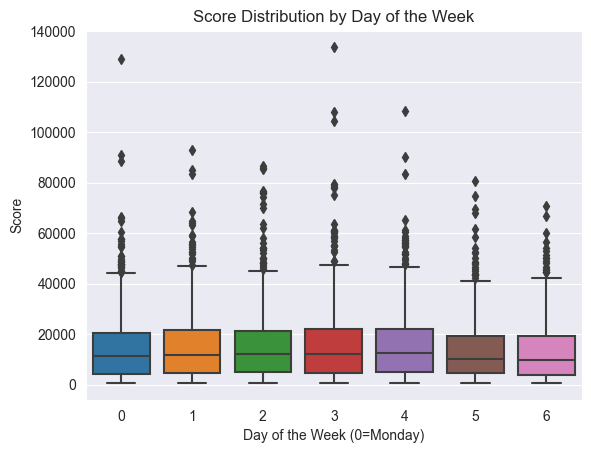

In [40]:
# Box plot of score by day of week
# Create 'day_of_week' column from one-hot encoded features
dow_cols = ['dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6']
df['day_of_week'] = df[dow_cols].idxmax(axis=1).str.replace('dow_', '').astype(int)

sns.boxplot(x='day_of_week', y='score', data=df)
plt.title('Score Distribution by Day of the Week')
plt.xlabel('Day of the Week (0=Monday)')
plt.ylabel('Score')
plt.show()


#### 4.6: Identify and Handle Outliers

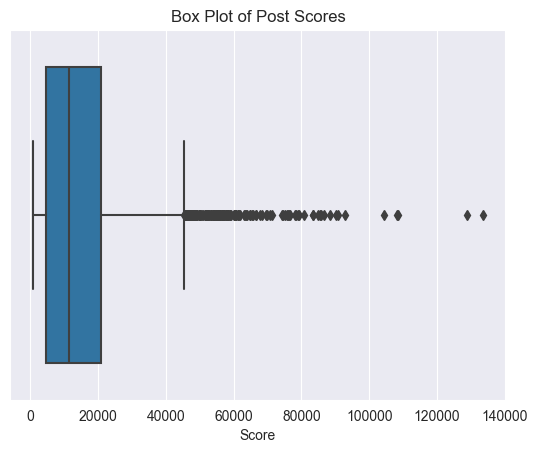

In [41]:
# visualise outliers using boxplot
sns.boxplot(x=df['score'])
plt.title('Box Plot of Post Scores')
plt.xlabel('Score')
plt.show()

In [42]:
# calculate the IQR
Q1 = df['score'].quantile(0.25)
Q3 = df['score'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")

Lower bound: -19965.75, Upper bound: 45266.25


In [43]:
# identify outliers
outliers = df[(df['score'] < lower_bound) | (df['score'] > upper_bound)]
print(f"Number of outliers: {len(outliers)}")

Number of outliers: 162


In [44]:
# remove outliers
df = df[(df['score'] >= lower_bound) & (df['score'] <= upper_bound)]
print(f"Number of rows after removing outliers: {len(df)}")

Number of rows after removing outliers: 4754


#### 4.7: Analyze Embedding Features
Given the high-dimensional embedding features, it's helpful to explore their variance and potential redundancy.

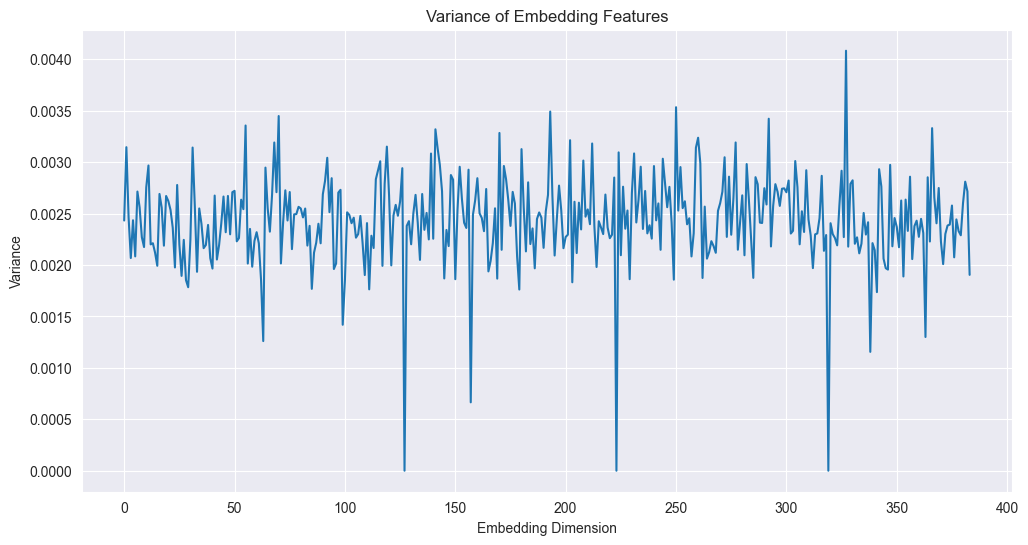

In [45]:
embedding_cols = [f'embedding_{i}' for i in range(384)]
embedding_variances = df[embedding_cols].var()

# Plot variance
plt.figure(figsize=(12, 6))
plt.plot(range(len(embedding_variances)), embedding_variances)
plt.title('Variance of Embedding Features')
plt.xlabel('Embedding Dimension')
plt.ylabel('Variance')
plt.show()

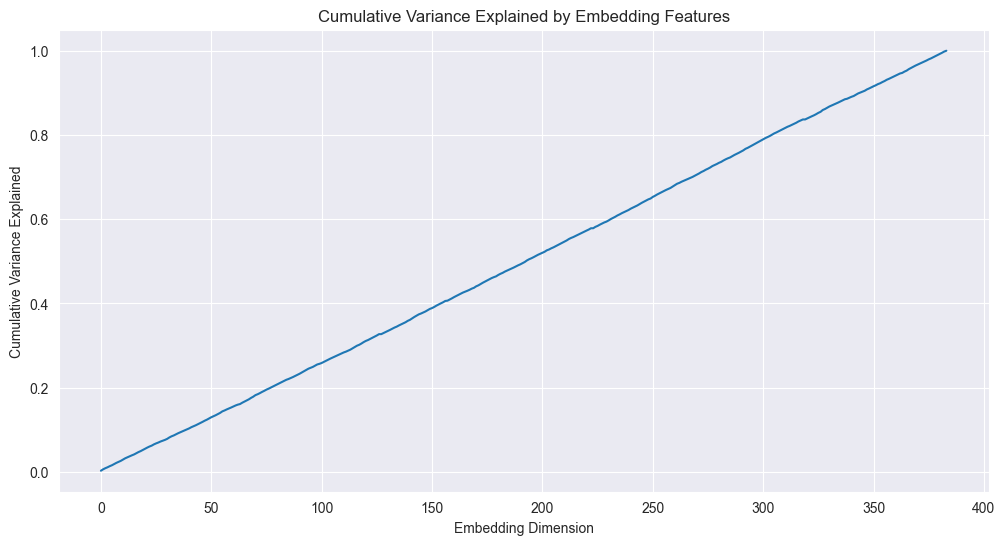

In [46]:
# Cumulative variance explained
cumulative_variance = embedding_variances.cumsum() / embedding_variances.sum()

# Plot cumulative variance
plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_variance)), cumulative_variance)
plt.title('Cumulative Variance Explained by Embedding Features')
plt.xlabel('Embedding Dimension')
plt.ylabel('Cumulative Variance Explained')
plt.show()

<li>Variance of Embedding Features Plot: The variance is evenly spread across all embedding dimensions, with minor fluctuations.
<li>Cumulative Variance Explained by Embedding Features Plot: The embedding features progressively explain more variance as you increase the number of dimensions, and by dimension 400, they explain all of it.

#### 4.8: Feature Importance and Selection

In [47]:
# Correlation with Target Variable:
correlations = df.corr()['score'].sort_values(ascending=False)
print(correlations.head(15))  # Top positive correlations
print(correlations.tail(15))  # Top negative correlations

/var/folders/b8/_x62wfl112g_8f32jdl3v95h0000gn/T/ipykernel_17990/157711516.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = df.corr()['score'].sort_values(ascending=False)


score                 1.000000
log_score             0.893181
subreddit_politics    0.496569
num_comments          0.442711
subreddit_news        0.320210
embedding_65          0.303380
embedding_292         0.286761
embedding_160         0.278823
embedding_247         0.273235
embedding_304         0.267824
embedding_376         0.231907
embedding_19          0.231584
embedding_77          0.228096
embedding_245         0.225219
embedding_368         0.223714
Name: score, dtype: float64
embedding_142        -0.198027
embedding_194        -0.198099
embedding_305        -0.198409
embedding_249        -0.209875
sentiment_POSITIVE   -0.212573
created_utc          -0.224545
embedding_202        -0.224561
embedding_126        -0.228679
embedding_13         -0.230504
embedding_307        -0.237245
embedding_231        -0.239179
embedding_184        -0.239757
subreddit_movies     -0.254423
embedding_54         -0.255964
subreddit_sports     -0.508804
Name: score, dtype: float64


##### Dimensionality Reduction of Embeddings using PCA

In [48]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)  # Reduce to 50 components
embeddings_reduced = pca.fit_transform(df[embedding_cols])

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Total Explained Variance with 50 components: {explained_variance:.2%}")

# Add reduced embeddings back to DataFrame
pca_cols = [f'pca_{i}' for i in range(50)]
df_pca = pd.DataFrame(embeddings_reduced, columns=pca_cols)
df = pd.concat([df.reset_index(drop=True), df_pca.reset_index(drop=True)], axis=1)

# Optionally drop original embedding columns
df.drop(columns=embedding_cols, inplace=True)

Total Explained Variance with 50 components: 51.67%


In [49]:
# Identify numerical and categorical columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['score', 'num_comments', 'upvote_ratio', 'created_utc', 'hour', 'day', 'month', 'year', 'is_weekend', 'text_length', 'subreddit_movies', 'subreddit_news', 'subreddit_politics', 'subreddit_sports', 'subreddit_technology', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'dow_5', 'dow_6', 'sentiment_NEGATIVE', 'sentiment_POSITIVE', 'log_score', 'day_of_week', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18', 'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25', 'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32', 'pca_33', 'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39', 'pca_40', 'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46', 'pca_47', 'pca_48', 'pca_49']
Categorical columns: ['id', 'title', 'selftext', 'text', 'subreddit', 'sentiment']


In [50]:
# from sklearn.feature_selection import SelectKBest, f_regression
# 
# Select features and target variable
# Assuming 'X' is your feature matrix and 'y' is your target variable
X = df.drop(columns=['score', 'id', 'title', 'selftext', 'text', 'log_score', 'created_datetime', 'subreddit', 'sentiment'])
y = df['score']

 
# selector = SelectKBest(score_func=f_regression, k=20)
# selector.fit(X, y)
# 
# selected_features = X.columns[selector.get_support()]
# print("Selected Features:",selected_features)
# # Save selected features
# import joblib
# joblib.dump(selected_features, 'models/selected_features.pkl')


### Step 5: Model Building

Target Variable: 'score'
<br>Features: All numerical features, one-hot encoded categorical features, and embeddings (PCA reduced)
<br>
<br>
<li>Regression Task: Predict the exact number of upvotes.

In [51]:
# X = df[selected_features]

# Check for missing values
missing_values = X.isnull().sum()
print("Missing values in each feature:\n", missing_values[missing_values > 0])

Missing values in each feature:
 Series([], dtype: int64)


In [52]:
# feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### 5.1: Train-Test Split

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [54]:
# check the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (3803, 74) (3803,)
Testing set shape: (951, 74) (951,)


#### 5.2: Model Selection and Evaluation
<ol>
<li>Linear Models:
<ul>
<li>Ridge Regression: Linear regression with L2 regularization.
<li>Lasso Regression: Linear regression with L1 regularization (can perform feature selection).
<li>Elastic Net: Combination of L1 and L2 regularization.
</ul>

<li>Tree-Based Models:
<ul>
<li>Random Forest Regressor: Handles high-dimensional data and non-linear relationships.
<li>Gradient Boosting Machines: Such as XGBoost, LightGBM, or CatBoost.
</ul>

<li>Support Vector Machines:
<ul><li>SVR (Support Vector Regression): Effective in high-dimensional spaces.</ul>

<li>Neural Networks:
<ul>
<li>Multi-Layer Perceptron (MLP): Can capture complex patterns.


#### 5.3: Model Training 
<br>
 5.3.1: Linear Regression

In [58]:
# Ridge Regression

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# initialize the model
ridge = Ridge(alpha=1.0)

# fit the model
ridge.fit(X_train, y_train)

# make predictions
y_pred_train_ridge = ridge.predict(X_train)
y_pred_ridge = ridge.predict(X_test)

# evaluate the model
mse_train_ridge = mean_squared_error(y_train, y_pred_train_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

r2_train_ridge = r2_score(y_train, y_pred_train_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression:")
print(f"Training MSE: {mse_train_ridge:.2f}, Test MSE: {mse_ridge:.2f}")
print(f"Training R^2: {r2_train_ridge:.2f}, Test R^2: {r2_ridge:.2f}")

Ridge Regression:
Training MSE: 39535552.29, Test MSE: 35864383.00
Training R^2: 0.64, Test R^2: 0.66


In [59]:
# Lasso Regression

from sklearn.linear_model import Lasso

# initialize the model
lasso = Lasso(alpha=0.1)

# fit the model
lasso.fit(X_train, y_train)

# make predictions
y_pred_train_lasso = lasso.predict(X_train)
y_pred_lasso = lasso.predict(X_test)

# evaluate the model
mse_train_lasso = mean_squared_error(y_train, y_pred_train_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

r2_train_lasso = r2_score(y_train, y_pred_train_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression:")
print(f"Training MSE: {mse_train_lasso:.2f}, Test MSE: {mse_lasso:.2f}")
print(f"Training R^2: {r2_train_lasso:.2f}, Test R^2: {r2_lasso:.2f}")

Lasso Regression:
Training MSE: 39535699.36, Test MSE: 35864256.84
Training R^2: 0.64, Test R^2: 0.66


/Users/shagundeepsingh/PycharmProjects/Reddit_post_popularity_predict/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.505e+10, tolerance: 4.149e+07
  model = cd_fast.enet_coordinate_descent(


5.3.2: Tree-Based Models

In [60]:
# Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor

# initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model
rf.fit(X_train, y_train)

# make predictions
y_pred_train_rf = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

# evaluate the model
mse_train_rf = mean_squared_error(y_train, y_pred_train_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)

r2_train_rf = r2_score(y_train, y_pred_train_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor:")
print(f"Training MSE: {mse_train_rf:.2f}, Test MSE: {mse_rf:.2f}")
print(f"Training R^2: {r2_train_rf:.2f}, Test R^2: {r2_rf:.2f}")

Random Forest Regressor:
Training MSE: 4274808.49, Test MSE: 27632119.59
Training R^2: 0.96, Test R^2: 0.74


In [35]:
# XGBoost Regressor

from xgboost import XGBRegressor

# initialize the model
xgb = XGBRegressor(n_estimators=100, random_state=42)

# fit the model
xgb.fit(X_train, y_train)

# make predictions
y_pred_train_xgb = xgb.predict(X_train)
y_pred_xgb = xgb.predict(X_test)

# evaluate the model
mse_train_xgb = mean_squared_error(y_train, y_pred_train_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

r2_train_xgb = r2_score(y_train, y_pred_train_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regressor:")
print(f"Training MSE: {mse_train_xgb:.2f}, Test MSE: {mse_xgb:.2f}")
print(f"Training R^2: {r2_train_xgb:.2f}, Test R^2: {r2_xgb:.2f}")

XGBoost Regressor:
Training MSE: 0.00, Test MSE: 0.16
Training R^2: 1.00, Test R^2: 0.72


In [36]:
# LightGBM Regressor

from lightgbm import LGBMRegressor

# initialize the model
lgbm = LGBMRegressor(n_estimators=100, random_state=42)

# fit the model
lgbm.fit(X_train, y_train)

# make predictions
y_pred_train_lgbm = lgbm.predict(X_train)
y_pred_lgbm = lgbm.predict(X_test)

# evaluate the model
mse_train_lgbm = mean_squared_error(y_train, y_pred_train_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)

r2_train_lgbm = r2_score(y_train, y_pred_train_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("LightGBM Regressor:")
print(f"Training MSE: {mse_train_lgbm:.2f}, Test MSE: {mse_lgbm:.2f}")
print(f"Training R^2: {r2_train_lgbm:.2f}, Test R^2: {r2_lgbm:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13535
[LightGBM] [Info] Number of data points in the train set: 3803, number of used features: 74
[LightGBM] [Info] Start training from score -0.112805
LightGBM Regressor:
Training MSE: 0.03, Test MSE: 0.14
Training R^2: 0.95, Test R^2: 0.75


5.3.3: Support Vector Machines

In [37]:
# SVR

from sklearn.svm import SVR

# initialize the model
svr = SVR()

# fit the model
svr.fit(X_train, y_train)

# make predictions
y_pred_train_svr = svr.predict(X_train)
y_pred_svr = svr.predict(X_test)

# evaluate the model
mse_train_svr = mean_squared_error(y_train, y_pred_train_svr)
mse_svr = mean_squared_error(y_test, y_pred_svr)

r2_train_svr = r2_score(y_train, y_pred_train_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("SVR:")
print(f"Training MSE: {mse_train_svr:.2f}, Test MSE: {mse_svr:.2f}")
print(f"Training R^2: {r2_train_svr:.2f}, Test R^2: {r2_svr:.2f}")

SVR:
Training MSE: 0.06, Test MSE: 0.17
Training R^2: 0.90, Test R^2: 0.71


5.3.4: Neural Networks

In [38]:
# Multi-Layer Perceptron (MLP)

from sklearn.neural_network import MLPRegressor

# initialize the model
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# fit the model
mlp.fit(X_train, y_train)

# make predictions
y_pred_train_mlp = mlp.predict(X_train)
y_pred_mlp = mlp.predict(X_test)

# evaluate the model
mse_train_mlp = mean_squared_error(y_train, y_pred_train_mlp)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)

r2_train_mlp = r2_score(y_train, y_pred_train_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP:")
print(f"Training MSE: {mse_train_mlp:.2f}, Test MSE: {mse_mlp:.2f}")
print(f"Training R^2: {r2_train_mlp:.2f}, Test R^2: {r2_mlp:.2f}")

MLP:
Training MSE: 0.00, Test MSE: 0.27
Training R^2: 1.00, Test R^2: 0.54


In [39]:
# Comparison of Model Performance

models = ['Ridge Regression', 'Lasso Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVR', 'MLP']
train_mse = [mse_train_ridge, mse_train_lasso, mse_train_rf, mse_train_xgb, mse_train_lgbm, mse_train_svr, mse_train_mlp]
test_mse = [mse_ridge, mse_lasso, mse_rf, mse_xgb, mse_lgbm, mse_svr, mse_mlp]

train_r2 = [r2_train_ridge, r2_train_lasso, r2_train_rf, r2_train_xgb, r2_train_lgbm, r2_train_svr, r2_train_mlp]
test_r2 = [r2_ridge, r2_lasso, r2_rf, r2_xgb, r2_lgbm, r2_svr, r2_mlp]

results = pd.DataFrame({
    'Model': models,
    'Train MSE': train_mse,
    'Test MSE': test_mse,
    'Train R^2': train_r2,
    'Test R^2': test_r2
})

results

,Model,Train MSE,Test MSE,Train R^2,Test R^2
0,Ridge Regression,0.217473,0.197463,0.637634,0.657692
1,Lasso Regression,0.270414,0.245150,0.549422,0.575026
2,Random Forest,0.023105,0.149634,0.961502,0.740606
3,XGBoost,0.001990,0.162980,0.996684,0.717470
4,LightGBM,0.028091,0.144070,0.953194,0.750250
5,SVR,0.057924,0.168370,0.903483,0.708125
6,MLP,0.002524,0.266935,0.995795,0.537261


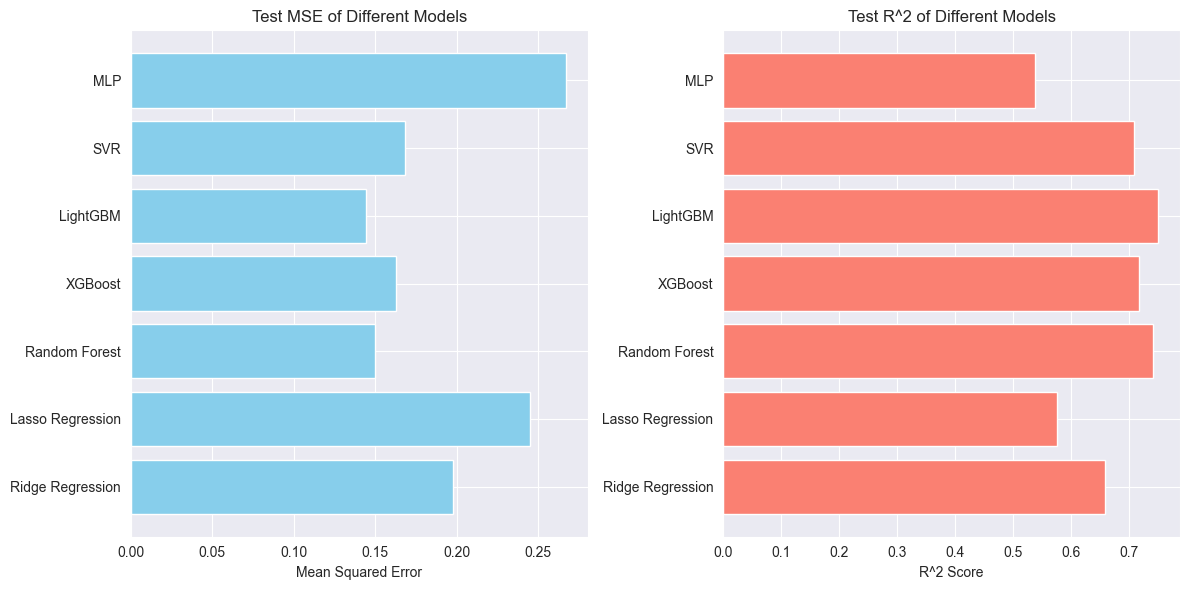

In [40]:
# Visualizing Model Performance

plt.figure(figsize=(12, 6))

# MSE
plt.subplot(1, 2, 1)
plt.barh(models, test_mse, color='skyblue')
plt.xlabel('Mean Squared Error')
plt.title('Test MSE of Different Models')

# R^2
plt.subplot(1, 2, 2)
plt.barh(models, test_r2, color='salmon')
plt.xlabel('R^2 Score')
plt.title('Test R^2 of Different Models')

plt.tight_layout()
plt.show()

#### 5.4: Hyperparameter Tuning

In [61]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

grid_search_rf.fit(X_train, y_train)

print(f"Best parameters: {grid_search_rf.best_params_}")
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the tuned model
y_pred_best_rf = best_rf_model.predict(X_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"Tuned Random Forest MSE: {mse_best_rf:.2f}")
print(f"Tuned Random Forest R^2 Score: {r2_best_rf:.2f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
	- Avoid u

Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Tuned Random Forest MSE: 27110453.11
Tuned Random Forest R^2 Score: 0.74


#### 5.5: Residual Analysis

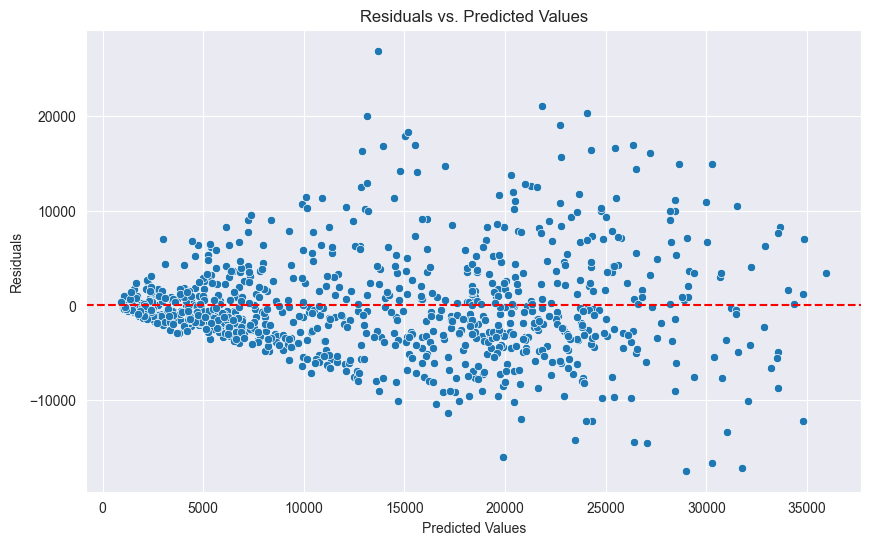

In [63]:
# Calculate residuals
residuals = y_test - y_pred_best_rf

# Plot residuals vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_best_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

The residual plot shows a random scatter of residuals around the zero line, indicating that the model has no significant patterns in the errors, suggesting that the model is likely appropriate for the data, though some heteroscedasticity (non-constant variance) is visible, especially with larger predicted values

#### 5.6: Feature Importance

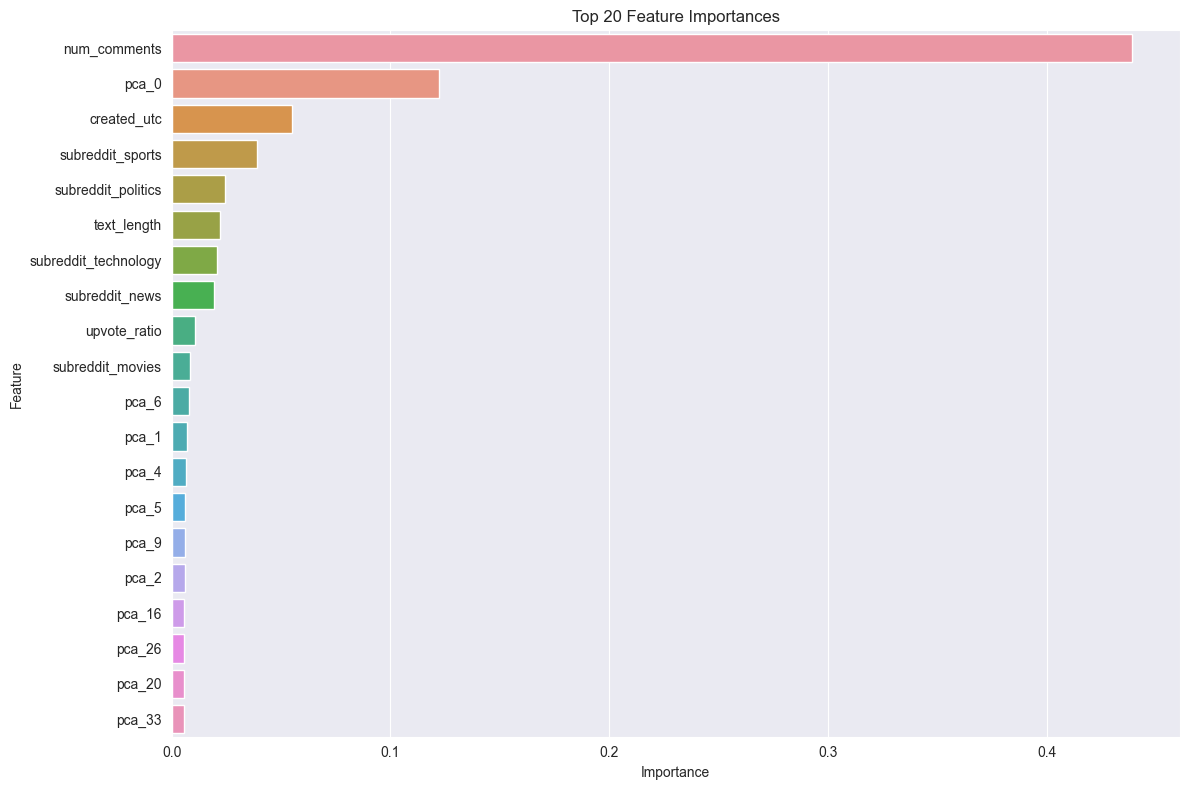

In [64]:
# Feature importance from the best Random Forest model
importances = best_rf_model.feature_importances_
feature_names = X.columns  # Ensure this matches the features used

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importance_df.head(20)
)
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

#### 5.7 Removing Un important features

In [66]:
X.sample()

,num_comments,upvote_ratio,created_utc,hour,day,month,year,is_weekend,text_length,subreddit_movies,...,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
2598,1426,0.97,1.711610e+09,7,28,3,2024,0,11,0,...,-0.131805,0.002565,0.000315,0.066735,0.014049,-0.106176,-0.127123,-0.012825,0.108365,-0.12738


In [71]:
X.columns

Index(['num_comments', 'upvote_ratio', 'is_weekend', 'text_length',
       'subreddit_movies', 'subreddit_news', 'subreddit_politics',
       'subreddit_sports', 'subreddit_technology', 'sentiment_NEGATIVE',
       'sentiment_POSITIVE', 'pca_0', 'pca_1', 'pca_2', 'pca_3', 'pca_4',
       'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10', 'pca_11',
       'pca_12', 'pca_13', 'pca_14', 'pca_15', 'pca_16', 'pca_17', 'pca_18',
       'pca_19', 'pca_20', 'pca_21', 'pca_22', 'pca_23', 'pca_24', 'pca_25',
       'pca_26', 'pca_27', 'pca_28', 'pca_29', 'pca_30', 'pca_31', 'pca_32',
       'pca_33', 'pca_34', 'pca_35', 'pca_36', 'pca_37', 'pca_38', 'pca_39',
       'pca_40', 'pca_41', 'pca_42', 'pca_43', 'pca_44', 'pca_45', 'pca_46',
       'pca_47', 'pca_48', 'pca_49'],
      dtype='object')

In [68]:
# Remove unimportant features (based on feature importance analysis)
X = X.drop(columns=['dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6', 'created_utc', 'year', 'month', 'day', 'hour', 'day_of_week'])

# Re-train the model without these features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Proceed with re-training the model
best_rf_model.fit(X_scaled, y)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, n_estimators=200,
                      random_state=42)

### Step 6: Model Deployment

In [70]:
import joblib

# Save the model
joblib.dump(best_rf_model, 'models/reddit_post_popularity_model.pkl')

# Save the scaler (if used)
joblib.dump(scaler, 'models/scaler.pkl')

# Save the PCA transformer (if used)
joblib.dump(pca, 'models/pca_transformer.pkl');

### SHAP (SHapley Additive exPlanations) Analysis
<br>
SHAP is a unified approach to explain the output of any machine learning model. It connects game theory with local explanations, providing a method to compute the contribution of each feature to the prediction.
<br>

Key Benefits:
<li>Model-Agnostic: Works with any model type.
<li>Consistent Feature Attributions: Ensures that features contributing more to the model's output have larger SHAP values.
<li>Local and Global Interpretability: Provides explanations for individual predictions and overall model behavior.

In [45]:
# !pip install shap

For tree-based models like Random Forest and XGBoost, SHAP provides specialized explainers.

In [46]:
import shap

# Initialize JavaScript visualization
shap.initjs()

#### a. Import SHAP and Initialize Explainer

In [47]:
# Create an explainer for the Random Forest model
explainer_rf = shap.Explainer(best_rf_model)

# Calculate SHAP values for the test set
shap_values_rf = explainer_rf(X_test)

#### b. SHAP Summary Plot

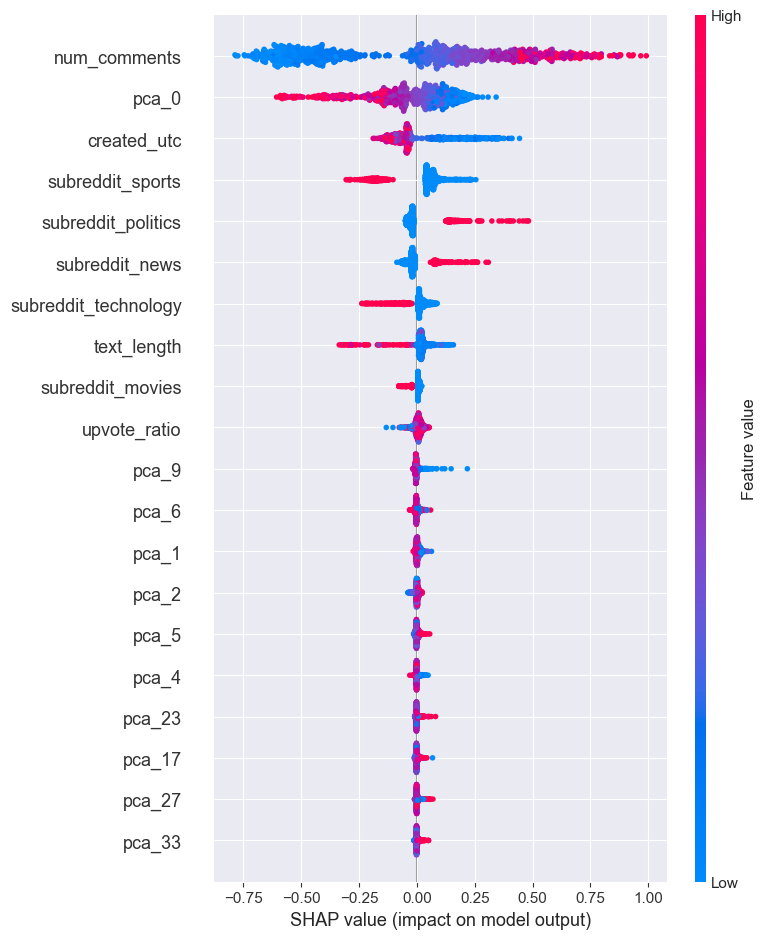

In [48]:
shap.summary_plot(shap_values_rf, X_test, feature_names=feature_names)

#### Interpretation:
<ol>

**Feature Importance**: Features are ranked in order of importance (top to bottom). <br>
**SHAP Value Magnitude**: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction. <br>
**Impact on Prediction**:
<ul>
<li>Positive SHAP Value: Feature increases the prediction having red color.
<li>Negative SHAP Value: Feature decreases the prediction having blue color.
<li>Color Intensity: Indicates the magnitude of the feature's effect.
</ul>
<br>
</ul>

**Color Coding**: Indicates the feature value (red high, blue low). <br>
